In [1]:
import sys
import os

import sqlite3
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import numpy as np

sys.path.insert(0, '../src') # add library code to path

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Processing Raw Data to Lightdump

In [2]:
from wikiparser import download_metadata_zips

zip_outdir = "../data/raw/zips"

download_metadata_zips(1, zip_outdir , False)

https://dumps.wikimedia.org/enwiki/20200401/enwiki-20200401-stub-meta-history1.xml.gz


In [3]:
zips = os.listdir(zip_outdir)
zips

['metadata-20200401-1.xml.gz',
 'metadata-20200101-1.xml.gz',
 'enwiki-20200101-0.7z',
 '.ipynb_checkpoints']

In [4]:
from wikiparser import gunzip_shutil

extract_outdir = "../data/raw/extracted"

for gzip_file in os.listdir(zip_outdir ):
    if gzip_file[-2:] == "gz":
        gunzip_shutil(zip_outdir + "/" + gzip_file, extract_outdir)
    

Extracted file already exists: ../data/raw/extracted/metadata-20200401-1.xml
Extracted file already exists: ../data/raw/extracted/metadata-20200101-1.xml


In [5]:
from wikiparser import parse_metadata_to_lightdump

#parse enwiki to lightdump
file_to_parse = "../data/raw/extracted/metadata-20200401-1.xml"
lightdump_filename = "popularity_dump.txt"
temp_dir = "../data/temp"
articles = ["Aardvark", 'Blizzard_Entertainment', 'American_League_Championship_Series']
# articles = []

In [6]:
parse_metadata_to_lightdump(file_to_parse , lightdump_filename, temp_dir, articles)

Lightdump File Already Exists


# Visualize Lightdump Article Byte Size

Starting Lightdump Parse for: American_League_Championship_Series
Finished Lightdump Parse => num revisions: 812
Saving plot to "../data/out/American_League_Championship_Series.png"


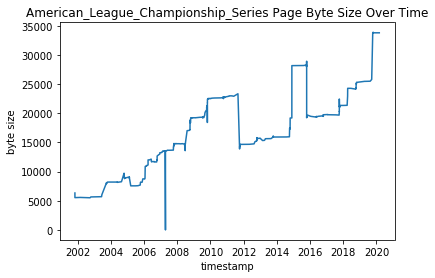

In [7]:
from engagement_score import create_wiki_graph

fig1 = create_wiki_graph("../data/temp/popularity_dump.txt", 'American_League_Championship_Series', "../data/out")

Starting Lightdump Parse for: Blizzard_Entertainment
Saving plot to "../data/out/Blizzard_Entertainment.png"


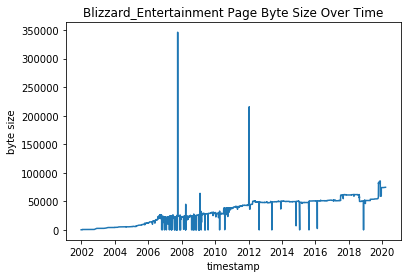

In [8]:
fig2 = create_wiki_graph("../data/temp/popularity_dump.txt", "Blizzard_Entertainment", "../data/out")

# Lightdump to DB Averaged by Month

In [9]:
#American_Football_Conference

In [10]:
from engagement_score import lightdump_to_db

lightdump_file = "../data/temp/popularity_dump.txt"
outfile = "../data/out/articles.db"
lightdump_to_db(lightdump_file, outfile)


DB File already exists


# Editor Engagement Score
* Penalize only few editors making a lot of edits
* We favor lots of edits from many unique editors over lots of edits from few people
* Sum the squares
* Multiple both numbers

In [11]:
from engagement_score import selectArticlesDB

aardvark = selectArticlesDB(outfile, ["Aardvark"])
blizzard = selectArticlesDB(outfile, ['Blizzard_Entertainment'])
mlb_alcs = selectArticlesDB(outfile, ['American_League_Championship_Series'])

SELECT * FROM ARTICLES WHERE article_title="Aardvark"
SELECT * FROM ARTICLES WHERE article_title="Blizzard_Entertainment"
SELECT * FROM ARTICLES WHERE article_title="American_League_Championship_Series"


In [12]:
mlb_alcs.head()

,timestamp,avg_bytes,edits,nunique_editors,article_title
0,2001-11-30,5544.0,1,1,American_League_Championship_Series
1,2001-12-31,0.0,0,0,American_League_Championship_Series
2,2002-01-31,0.0,0,0,American_League_Championship_Series
3,2002-02-28,5577.0,1,1,American_League_Championship_Series
4,2002-03-31,0.0,0,0,American_League_Championship_Series


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from engagement_score import editor_engagement_score

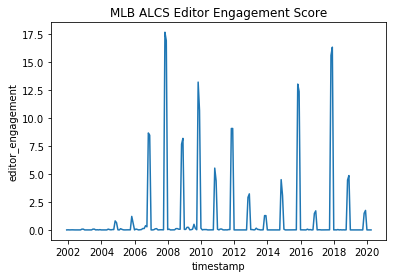

In [14]:
mlb_df = editor_engagement_score(mlb_alcs, '../data/out')
ax = sns.lineplot(x='timestamp', y='editor_engagement', data=mlb_df)
ax.set_title("MLB ALCS Editor Engagement Score")
plt.show()

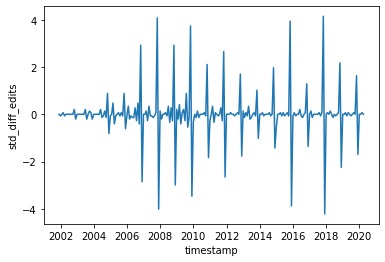

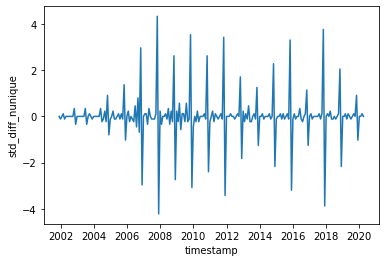

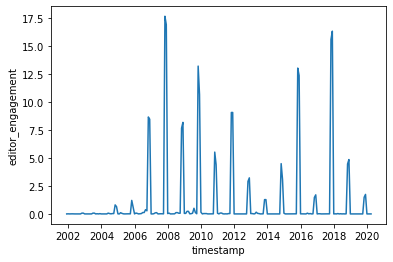

In [15]:
ax = sns.lineplot(x='timestamp', y='std_diff_edits', data=mlb_df)
plt.show()
ax = sns.lineplot(x='timestamp', y='std_diff_nunique', data=mlb_df)
plt.show()
ax = sns.lineplot(x='timestamp', y='editor_engagement', data=mlb_df)
plt.show()

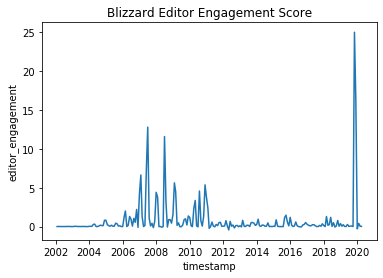

In [16]:
blizzard_df = editor_engagement_score(blizzard, '../data/out')
ax = sns.lineplot(x='timestamp', y='editor_engagement', data=blizzard_df)
ax.set_title("Blizzard Editor Engagement Score")
plt.show()

Writing Page View Data to -- ../data/temp/pageviews.csv


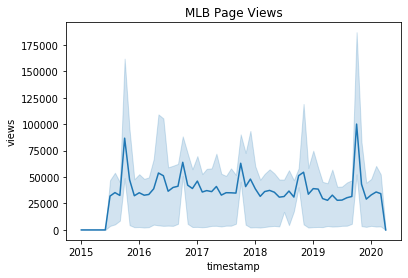

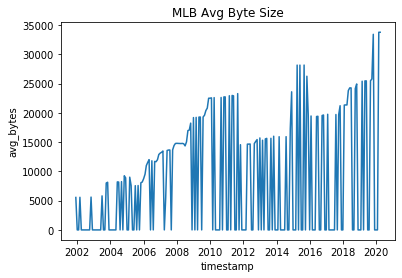

In [17]:
from engagement_score import get_page_views

articles = ["Aardvark", 'Blizzard_Entertainment', 'American_League_Championship_Series']

pageviews_outfile = temp_dir + "/pageviews.csv"
    
views_df = get_page_views(articles, pageviews_outfile)

views_df[views_df["article_title"] == 'American_League_Championship_Series']

ax = sns.lineplot(x='timestamp', y='views', data=views_df)
ax.set_title("MLB Page Views")
plt.show()

ax = sns.lineplot(x='timestamp', y='avg_bytes', data=mlb_alcs)
ax.set_title("MLB Avg Byte Size")
plt.show()

In [18]:
from engagement_score import content_engagement_score

db_outfile = "../data/out/articles.db"
pageviews_outfile = "../data/temp/pageviews.csv"
output_dir = "../data/out"

content_score = content_engagement_score(pageviews_outfile, db_outfile, output_dir + "/content_engagement.csv")
content_score.head()

Writing Content Engagement Score to -- ../data/out/content_engagement.csv


,article_title,timestamp,content_engagement
0,Aardvark,2015-08-01,0.004713
1,Aardvark,2015-09-01,-0.215383
2,Aardvark,2015-10-01,0.228697
3,Aardvark,2015-11-01,-0.018487
4,Aardvark,2015-12-01,0.004245


In [19]:
def joint_engagement(content_df, editor_df, article_name, outfile="./data/out"):
    editor_score = list(editor_df[editor_df['timestamp'] > '2015-08-01']['editor_engagement'])
    
    timestamps = list(content_df[content_df['article_title'] == article_name]['timestamp'])
    
    content_score = list(content_df[content_df['article_title'] == article_name]['content_engagement'])
    
    joint_score = [editor_score[i] * content_score[i] for i in range(len(editor_score))]
    
    df = pd.DataFrame({"article_title": [article_name for _ in range(len(joint_score))], 
                       "timestamp": timestamps,
                       "editor_score": editor_score, 
                       "content_score": content_score, 
                       "engagement_score": joint_score})
    
    df.to_csv(outfile + "/" + article_name + "-score.csv")
    
    return df

In [20]:
joint_blizzard = joint_engagement(content_score, blizzard_df, "Blizzard_Entertainment", '../data/out')

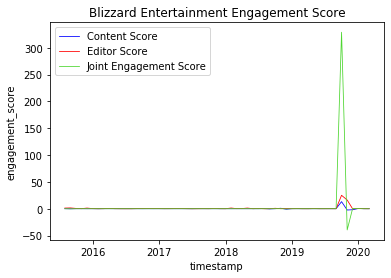

In [21]:
sns.set_context(rc={"lines.linewidth": .80})

ax = sns.lineplot(x='timestamp', y='content_score', data=joint_blizzard, label="Content Score", color="blue")
ax.set_title("Blizzard Entertainment Content Score")

ax = sns.lineplot(x='timestamp', y='editor_score', data=joint_blizzard, label="Editor Score", color="red")
ax.set_title("Blizzard Entertainment Editor Score")

ax = sns.lineplot(x='timestamp', y='engagement_score', data=joint_blizzard, label="Joint Engagement Score", color="#4FD632")

ax.set_title("Blizzard Entertainment Engagement Score")
ax.legend()

plt.show()

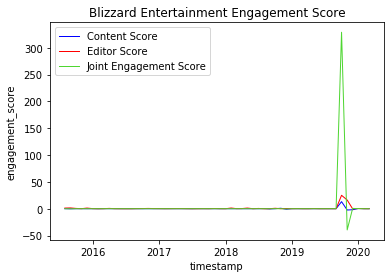

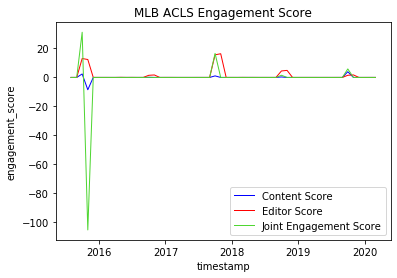

In [22]:
sns.set_context(rc={"lines.linewidth": 1.0})

ax = sns.lineplot(x='timestamp', y='content_score', data=joint_blizzard, label="Content Score", color="blue")
ax.set_title("Blizzard Entertainment Content Score")

ax = sns.lineplot(x='timestamp', y='editor_score', data=joint_blizzard, label="Editor Score", color="red")
ax.set_title("Blizzard Entertainment Editor Score")

ax = sns.lineplot(x='timestamp', y='engagement_score', data=joint_blizzard, label="Joint Engagement Score", color="#4FD632")

ax.set_title("Blizzard Entertainment Engagement Score")
ax.legend()

plt.show()

joint_mlb = joint_engagement(content_score, mlb_df, "American_League_Championship_Series", '../data/out')

ax = sns.lineplot(x='timestamp', y='content_score', data=joint_mlb, label="Content Score", color="blue")
ax.set_title("MLB ACLS Content Score")

ax = sns.lineplot(x='timestamp', y='editor_score', data=joint_mlb, label="Editor Score", color="red")
ax.set_title("MLB ACLS Editor Score")

ax = sns.lineplot(x='timestamp', y='engagement_score', data=joint_mlb, label="Joint Engagement Score", color="#4FD632")
ax.set_title("MLB ACLS Engagement Score")
ax.legend()

plt.show()

In [29]:
conn = sqlite3.connect("../data/out/engagement_scores.db")
c = conn.cursor()
joint_df = pd.concat([joint_blizzard, joint_mlb])
joint_df.to_sql('SCORES', conn, if_exists='replace', index=False)